In [27]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
import time
import importlib
import pandas as pd
import numpy as np
import pickle
import nn_utils as nn
importlib.reload(nn)

<module 'nn_utils' from 'c:\\Users\\zodes\\Documents\\Academics\\UChicago MPCS\\Machine Learning\\coding-ml-algos\\neural_networks\\nn_utils.py'>

In [28]:
class FailTestError(Exception):
    'Raised when a test fails'
    pass

### Test cases to help debug getting and setting weights

In [29]:
nn.test_set_and_get_weights()

Passed the test for set_weights and get_weights.


### Test cases to help debug the different operation classes

In [30]:
m1 = nn.Value(np.arange(12).reshape((3,4)))
m2 = nn.Value(np.arange(12,24).reshape((3,4)))
m3 = nn.Value(np.arange(24,36).reshape((3,4)))
m4 = nn.Value(np.arange(36,48).reshape((3,4)))

v1 = nn.Value(np.arange(3).reshape((3,)))
v2 = nn.Value(np.arange(3,6).reshape((3,)))
v3 = nn.Value(np.arange(6,9).reshape((3,)))
v4 = nn.Value(np.arange(4).reshape((4,)))

In [31]:
#Test VDot
x = nn.Mul(m1, m2)
y = nn.VDot(v1, x)
z = nn.Mul(y, v4)
x.forward()
y.forward()
z.forward()
z.grad = np.ones_like(z.value)
y.grad = 0
x.grad = 0
v1.grad = 0
z.backward()
y.backward()
x.backward()

yvalue = np.array([384., 463., 548., 639.])
ygrad = np.array([0., 1., 2., 3.])
yagrad = np.array([ 204.,  700., 1388.])
ybgrad = np.array([[0., 0., 0., 0.],
                   [0., 1., 2., 3.],
                   [0., 2., 4., 6.]])

if not np.array_equal(y.value, yvalue):
    raise FailTestError("y.value not equal to matrix product of x.value and v1.value")
if not np.array_equal(y.grad, ygrad):
    raise FailTestError("gradient of y is incorrect")
if not np.array_equal(y.a.grad, yagrad):
    raise FailTestError("gradient of a in y is incorrect")
if not np.array_equal(y.b.grad, ybgrad):
    raise FailTestError("gradient of b in y is incorrect")
print("Passed Test on VDot")

Passed Test on VDot


In [32]:
# Test Sigmoid
x = nn.Add(v1, v2)
y = nn.Sigmoid(x)
z = nn.Mul(y, v3)
x.forward()
y.forward()
z.forward()
z.grad = np.ones_like(z.value)
y.grad = 0
x.grad = 0
z.backward()
y.backward()
x.backward()

yvalue = np.array([0.95257413, 0.9933072 , 0.999089], dtype=np.float32)
yagrad = np.array([0.2710599 , 0.04653623, 0.00728134], dtype=np.float32)

if not np.array_equal(np.round(y.value, 5), np.round(yvalue, 5)):
    raise FailTestError("y.value not equal to sigmoid of x")
if not np.array_equal(np.round(y.a.grad, 5), np.round(yagrad, 5)):
    raise FailTestError("gradient of a in y is incorrect")
print("Passed Test on Sigmoid")

Passed Test on Sigmoid


In [33]:
# Test RELU
x = nn.Add(v1, v2)
y = nn.RELU(x)
z = nn.Mul(y, v3)
x.forward()
y.forward()
z.forward()
z.grad = np.ones_like(z.value)
y.grad = 0
x.grad = 0
z.backward()
y.backward()
x.backward()

yvalue = np.array([3., 5., 7.], dtype=np.float32)
yagrad = np.array([6., 7., 8.], dtype=np.float32)

if not np.array_equal(np.round(y.value, 5), np.round(yvalue, 5)):
    raise FailTestError("y.value not equal to Relu of x")
if not np.array_equal(np.round(y.a.grad, 5), np.round(yagrad, 5)):
    raise FailTestError("gradient of a in y is incorrect")
print("Passed Test on RELU")

Passed Test on RELU


In [34]:
# Test SoftMax
x = nn.Add(v1, v2)
y = nn.SoftMax(x)
z = nn.Mul(y, v3)
x.forward()
y.forward()
z.forward()
z.grad = np.ones_like(z.value)
y.grad = 0
x.grad = 0
z.backward()
y.backward()
x.backward()

yvalue = np.array([0.01587624, 0.11731043, 0.86681336], dtype=np.float32)
yagrad = np.array([-0.02938593, -0.09982383,  0.12920949], dtype=np.float32)

if not np.array_equal(np.round(y.value, 5), np.round(yvalue, 5)):
    raise FailTestError("y.value not equal to SoftMax of x")
if not np.array_equal(np.round(y.a.grad, 5), np.round(yagrad, 5)):
    raise FailTestError("gradient of a in y is incorrect")
print("Passed Test on SoftMax")

Passed Test on SoftMax


In [35]:
# Test Log
x = nn.Add(v1, v2)
y = nn.Log(x)
z = nn.Mul(y, v3)
x.forward()
y.forward()
z.forward()
z.grad = np.ones_like(z.value)
y.grad = 0
x.grad = 0
z.backward()
y.backward()
x.backward()

yvalue = np.array([1.0986123, 1.609438 , 1.9459102], dtype=np.float32)
yagrad = np.array([2.       , 1.4      , 1.1428572], dtype=np.float32)

if not np.array_equal(np.round(y.value, 5), np.round(yvalue, 5)):
    raise FailTestError("y.value not equal to log of x")
if not np.array_equal(np.round(y.a.grad, 5), np.round(yagrad, 5)):
    raise FailTestError("gradient of a in y is incorrect")
print("Passed Test on Log")

Passed Test on Log


## Applying to the MNIST dataset

In [36]:
data = pd.read_csv("./mnist_data/train.csv")
train_data = data.iloc[:30000]  # 30000
test_data = data.iloc[30000:]  # 12000

pixel_columns = [f"pixel{i}" for i in range(784)]

# normalize by dividing by 255 as the pixel ranges from 0 to 255
train_x = train_data[pixel_columns].values.astype(nn.DT)/255
train_y = train_data["label"].values.astype(nn.DT)

test_x = test_data[pixel_columns].values.astype(nn.DT)/255
test_y = test_data["label"].values.astype(nn.DT)

### Debugging the fit function

In [37]:
nodes_array = [784, 128, 10]
model = nn.NN(nodes_array, "sigmoid")

# Provided sample weights for initialization
with open("./mnist_data/sample_weights.pkl", 'rb') as f:
    weights = pickle.load(f)
model.set_weights(weights)

X = train_x[:2]
y = train_y[:2]

model.fit(X, y, alpha=0.01, t=1)

# Load the sample gradient for debugging
with open("./mnist_data/sample_gradient.pkl", 'rb') as f:
    sample_grad = pickle.load(f)

# first layer's weight of shape (784, 128)
if not np.allclose(model.params["weight0"].grad, sample_grad["w1"]):
    print("should be", sample_grad["w1"])
    print("but is", model.params["weight0"].grad)
    raise FailTestError("gradient of the first layer's weight is incorrect")
# first layer's bias of shape (128, )
if not np.allclose(model.params["bias0"].grad, sample_grad["b1"]):
    raise FailTestError("gradient of the first layer's bias is incorrect")
# second layer's weight of shape (128, 10)
if not np.allclose(model.params["weight1"].grad, sample_grad["w2"]):
    raise FailTestError("gradient of the second layer's weight is incorrect")
# second layer's bias of shape (10, )
if not np.allclose(model.params["bias1"].grad, sample_grad["b2"]):
    raise FailTestError("gradient of the second layer's bias is incorrect")

Append <VDot> to the computational graph
Append <Add> to the computational graph
Append <Sigmoid> to the computational graph
Append <VDot> to the computational graph
Append <Add> to the computational graph
Append <SoftMax> to the computational graph
Append <Aref> to the computational graph
Append <Log> to the computational graph
Append <Mul> to the computational graph
Append <Accuracy> to the computational graph


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 0: train loss = 2.4059, accy = 0.5000, [0.005 secs]


### Training the NN on the whole training dataset

Append <VDot> to the computational graph
Append <Add> to the computational graph
Append <Sigmoid> to the computational graph
Append <VDot> to the computational graph
Append <Add> to the computational graph
Append <SoftMax> to the computational graph
Append <Aref> to the computational graph
Append <Log> to the computational graph
Append <Mul> to the computational graph
Append <Accuracy> to the computational graph


  0%|          | 0/30000 [00:00<?, ?it/s]

Epoch 0: train loss = 0.3189, accy = 0.9083, [19.296 secs]


  0%|          | 0/30000 [00:00<?, ?it/s]

Epoch 1: train loss = 0.2463, accy = 0.9283, [18.707 secs]


  0%|          | 0/30000 [00:00<?, ?it/s]

Epoch 2: train loss = 0.1979, accy = 0.9428, [18.125 secs]


  0%|          | 0/30000 [00:00<?, ?it/s]

Epoch 3: train loss = 0.1633, accy = 0.9531, [19.957 secs]


  0%|          | 0/30000 [00:00<?, ?it/s]

Epoch 4: train loss = 0.1381, accy = 0.9609, [19.679 secs]


  0%|          | 0/30000 [00:00<?, ?it/s]

Epoch 5: train loss = 0.1191, accy = 0.9658, [19.608 secs]


  0%|          | 0/30000 [00:00<?, ?it/s]

Epoch 6: train loss = 0.1042, accy = 0.9700, [20.241 secs]


  0%|          | 0/30000 [00:00<?, ?it/s]

Epoch 7: train loss = 0.0922, accy = 0.9739, [20.543 secs]


  0%|          | 0/30000 [00:00<?, ?it/s]

Epoch 8: train loss = 0.0821, accy = 0.9771, [19.750 secs]


  0%|          | 0/30000 [00:00<?, ?it/s]

Epoch 9: train loss = 0.0735, accy = 0.9799, [21.376 secs]


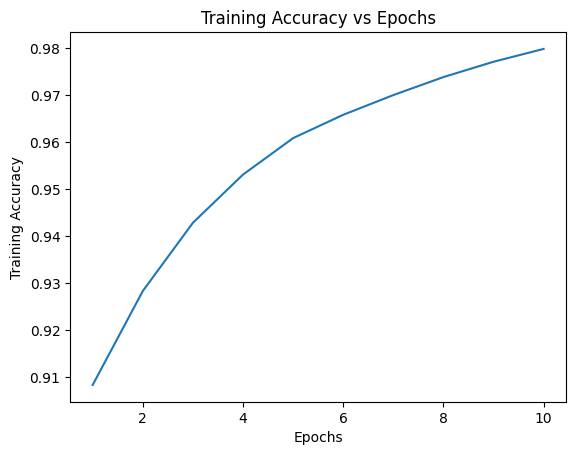

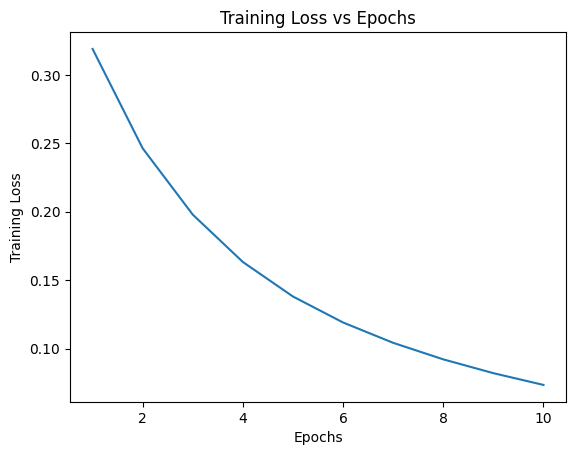

In [38]:
# 2-layer NN with 1 hidden layer
nodes_array = [784, 128, 10]
model = nn.NN(nodes_array, "sigmoid")
model.init_weights_with_xavier()
model.fit_plot(train_x, train_y, 0.01, 10)

In [39]:
accy, loss = model.eval(test_x, test_y)
print("Test accuracy = %.4f, loss = %.4f" % (accy, loss))

Test accuracy = 0.9643, loss = 0.1173


Append <VDot> to the computational graph
Append <Add> to the computational graph
Append <Sigmoid> to the computational graph
Append <VDot> to the computational graph
Append <Add> to the computational graph
Append <Sigmoid> to the computational graph
Append <VDot> to the computational graph
Append <Add> to the computational graph
Append <SoftMax> to the computational graph
Append <Aref> to the computational graph
Append <Log> to the computational graph
Append <Mul> to the computational graph
Append <Accuracy> to the computational graph


  0%|          | 0/30000 [00:00<?, ?it/s]

Epoch 0: train loss = 0.3690, accy = 0.8926, [22.774 secs]


  0%|          | 0/30000 [00:00<?, ?it/s]

Epoch 1: train loss = 0.2793, accy = 0.9178, [23.729 secs]


  0%|          | 0/30000 [00:00<?, ?it/s]

Epoch 2: train loss = 0.2203, accy = 0.9348, [23.480 secs]


  0%|          | 0/30000 [00:00<?, ?it/s]

Epoch 3: train loss = 0.1807, accy = 0.9459, [23.584 secs]


  0%|          | 0/30000 [00:00<?, ?it/s]

Epoch 4: train loss = 0.1513, accy = 0.9545, [22.940 secs]


  0%|          | 0/30000 [00:00<?, ?it/s]

Epoch 5: train loss = 0.1287, accy = 0.9616, [23.417 secs]


  0%|          | 0/30000 [00:00<?, ?it/s]

Epoch 6: train loss = 0.1103, accy = 0.9670, [23.099 secs]


  0%|          | 0/30000 [00:00<?, ?it/s]

Epoch 7: train loss = 0.0944, accy = 0.9722, [24.022 secs]


  0%|          | 0/30000 [00:00<?, ?it/s]

Epoch 8: train loss = 0.0807, accy = 0.9763, [23.925 secs]


  0%|          | 0/30000 [00:00<?, ?it/s]

Epoch 9: train loss = 0.0690, accy = 0.9798, [23.697 secs]


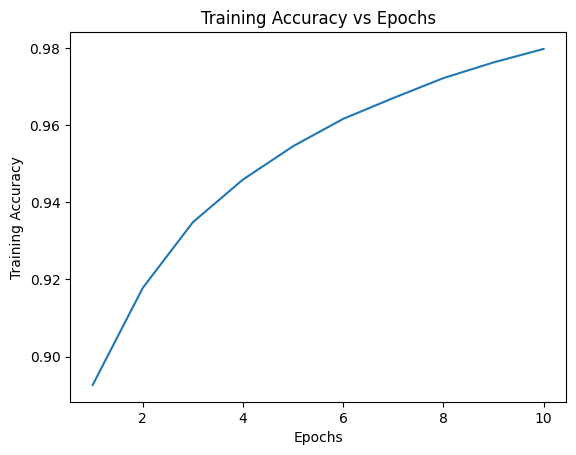

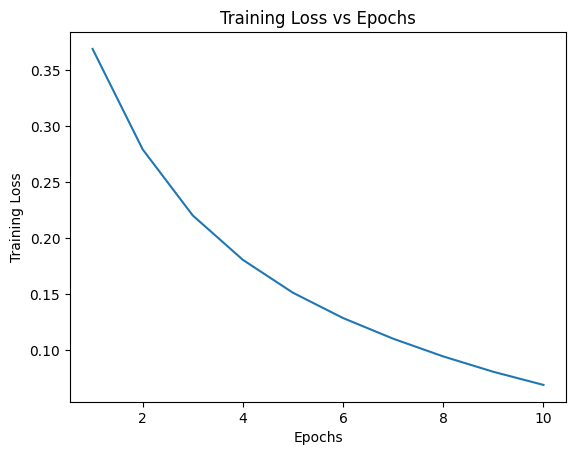

In [40]:
# 3-layer NN with 2 hidden layers
nodes_array = [784, 128, 64, 10]
model = nn.NN(nodes_array, "sigmoid")
model.init_weights_with_xavier()
model.fit_plot(train_x, train_y, 0.01, 10)

In [41]:
accy, loss = model.eval(test_x, test_y)
print("Test accuracy = %.4f, loss = %.4f" % (accy, loss))

Test accuracy = 0.9628, loss = 0.1207


Append <VDot> to the computational graph
Append <Add> to the computational graph
Append <RELU> to the computational graph
Append <VDot> to the computational graph
Append <Add> to the computational graph
Append <SoftMax> to the computational graph
Append <Aref> to the computational graph
Append <Log> to the computational graph
Append <Mul> to the computational graph
Append <Accuracy> to the computational graph


  0%|          | 0/30000 [00:00<?, ?it/s]

Epoch 0: train loss = 0.1670, accy = 0.9473, [26.557 secs]


  0%|          | 0/30000 [00:00<?, ?it/s]

Epoch 1: train loss = 0.1008, accy = 0.9678, [25.232 secs]


  0%|          | 0/30000 [00:00<?, ?it/s]

Epoch 2: train loss = 0.0676, accy = 0.9792, [25.417 secs]


  0%|          | 0/30000 [00:00<?, ?it/s]

Epoch 3: train loss = 0.0467, accy = 0.9858, [25.895 secs]


  0%|          | 0/30000 [00:00<?, ?it/s]

Epoch 4: train loss = 0.0343, accy = 0.9896, [25.463 secs]


  0%|          | 0/30000 [00:00<?, ?it/s]

Epoch 5: train loss = 0.0234, accy = 0.9932, [25.801 secs]


  0%|          | 0/30000 [00:00<?, ?it/s]

Epoch 6: train loss = 0.0182, accy = 0.9950, [25.052 secs]


  0%|          | 0/30000 [00:00<?, ?it/s]

Epoch 7: train loss = 0.0148, accy = 0.9962, [25.049 secs]


  0%|          | 0/30000 [00:00<?, ?it/s]

Epoch 8: train loss = 0.0115, accy = 0.9977, [24.502 secs]


  0%|          | 0/30000 [00:00<?, ?it/s]

Epoch 9: train loss = 0.0089, accy = 0.9979, [24.648 secs]


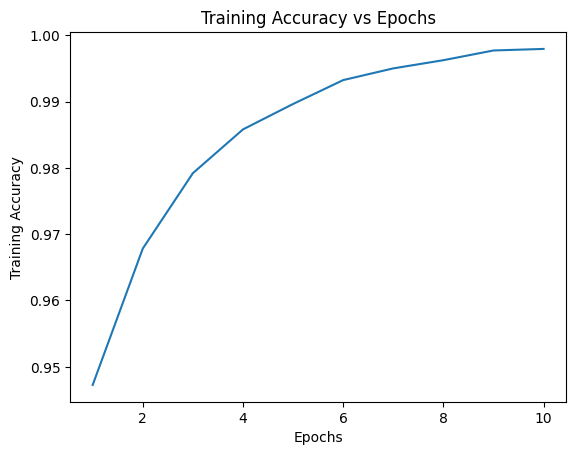

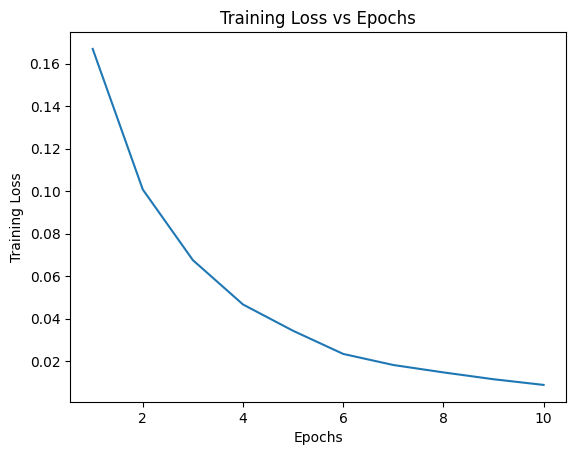

In [42]:
# 2-layer NN with 1 hidden layer, ReLU activation function
nodes_array = [784, 128, 10]
model = nn.NN(nodes_array, "relu")
model.init_weights_with_xavier()
model.fit_plot(train_x, train_y, 0.01, 10)

In [43]:
accy, loss = model.eval(test_x, test_y)
print("Test accuracy = %.4f, loss = %.4f" % (accy, loss))

Test accuracy = 0.9762, loss = 0.0991
